# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [6]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [7]:
# Shapes
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

#Dimensions
image_shape = x_train.shape[1:]
print(f"Image dimensions: {image_shape}")

# Number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Image dimensions: (32, 32, 3)
Number of classes: 100


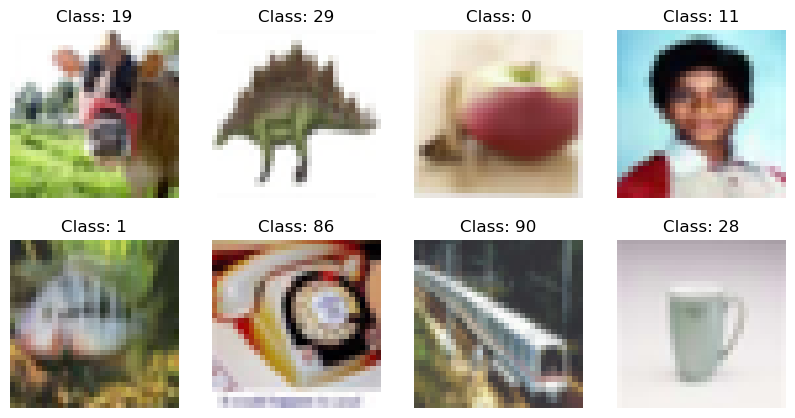

In [68]:
# Examples
from random import randint, seed 

plt.figure(figsize=(10, 5))
seed()
rand = randint(0,10)

for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(x_train[i+rand])
        plt.title(f"Class: {y_train[i+rand][0]}")
        plt.axis('off')
plt.show()

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [69]:
# Your code here
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


#OneHoT encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#Splitting training set and validation 80-20%
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Verify the shapes of the new training and validation sets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 100)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 100)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [73]:
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense

# Your code here

model = Sequential()

#Convolutional and maxpool layer 2
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='Valid'))

#Convolutional and maxpool layer 2
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='Valid'))
model.add(MaxPooling2D(pool_size=(2,2), padding='Valid'))

#Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5)) 
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 256)              

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> Categorical cross-entropy, because its used when there's 2 or more output labels
- <b>Optimizer:</b> SGD, because it performs better on image classification

In [74]:
from keras import optimizers
from keras.optimizers import SGD

# Your code here
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [75]:
# Your code here
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/20
1250/1250 [==============================] - 78s 59ms/step - loss: 4.5736 - accuracy: 0.0183 - val_loss: 4.4628 - val_accuracy: 0.0494
Epoch 2/20
1250/1250 [==============================] - 76s 61ms/step - loss: 4.3353 - accuracy: 0.0443 - val_loss: 4.1262 - val_accuracy: 0.0786
Epoch 3/20
1250/1250 [==============================] - 74s 60ms/step - loss: 4.1239 - accuracy: 0.0703 - val_loss: 3.9184 - val_accuracy: 0.1100
Epoch 4/20
1250/1250 [==============================] - 70s 56ms/step - loss: 3.9720 - accuracy: 0.0966 - val_loss: 3.7654 - val_accuracy: 0.1400
Epoch 5/20
1250/1250 [==============================] - 75s 60ms/step - loss: 3.8432 - accuracy: 0.1147 - val_loss: 3.6407 - val_accuracy: 0.1635
Epoch 6/20
1250/1250 [==============================] - 81s 65ms/step - loss: 3.7298 - accuracy: 0.1362 - val_loss: 3.5394 - val_accuracy: 0.1812
Epoch 7/20
1250/1250 [==============================] - 73s 59ms/step - loss: 3.6096 - accuracy: 0.1556 - val_loss: 3.4328 -

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 0.3250 
- <b>Other metric:</b> F1 score
- <b>Reason for selection:</b> it provides balanced evaluation with imbalanced datasets
- <b>Value of metric:</b> 0.3352
- <b>Interpretation of metric value:</b> the model performs better when the difference between false negatives and false positives is crucial. 

In [78]:
# Your code here
from sklearn.metrics import f1_score

y_pred = model.predict(x_test) 
y_pred_classes = y_pred.argmax(axis=-1)  

#  one-hot  
y_test_classes = y_test.argmax(axis=-1)  

# Compute F1-Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1-Score: {f1:.4f}')

313/313 [==============================] - 6s 19ms/step
F1-Score: 0.3352


### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. 
    
    What do the plots show? 

        it shows that the model is performing well until the 20 epochs where there's still no sign of overfitting on the validation data.
    
    Do the results make sense? 
    
        Yes, the model seems to have a good fitting  and it may seem like the dropout its making its job preventing overfitting but more epochs might be needed to verify a possible overfitting.
    
    What do the classification probabilities indicate?

        They predict the probability distribution over the classes given an input


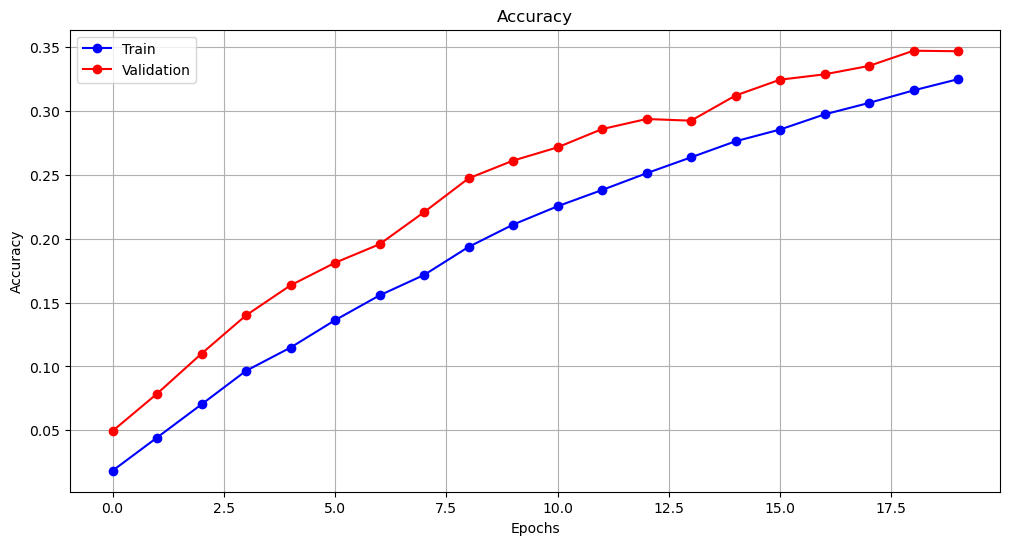

In [79]:
# Your code here

# Plot the training and validation accuracy:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], 'bo-', label='Train')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

313/313 [==============================] - 6s 20ms/step
Correctly Classified Image
[4.0680457e-05 3.2543836e-04 2.1767612e-03 3.1414668e-03 2.1509947e-02
 3.2745686e-04 1.7382683e-02 2.0218727e-03 1.5979989e-03 5.2514777e-04
 4.4225147e-03 2.9008288e-03 1.0022224e-03 5.7330960e-04 9.8442915e-04
 1.4491778e-02 1.2063002e-03 7.6311547e-04 3.4807257e-03 1.8038782e-03
 7.3480126e-03 4.5827273e-04 2.6517012e-03 6.1096449e-05 7.0045562e-03
 1.6370305e-03 1.9765846e-02 2.1564616e-03 4.2236908e-03 3.0055824e-01
 6.3166354e-04 1.4476231e-02 1.7287863e-02 2.6664333e-04 6.5807640e-03
 2.5281196e-03 3.3469170e-03 2.3062341e-03 2.0441949e-02 5.3340415e-03
 1.0273974e-02 7.7882178e-05 3.8609236e-02 1.7780503e-03 7.3129041e-03
 5.9748176e-03 2.0038257e-03 3.1070448e-03 2.8518616e-04 3.2452997e-04
 1.1468811e-01 1.7526357e-03 2.0769285e-03 3.6688554e-05 1.2506318e-04
 8.3914660e-03 6.5625166e-03 3.8195879e-04 1.5615918e-04 6.8497476e-03
 6.5366044e-06 3.0044845e-04 9.6358293e-05 7.2319815e-03 5.519782

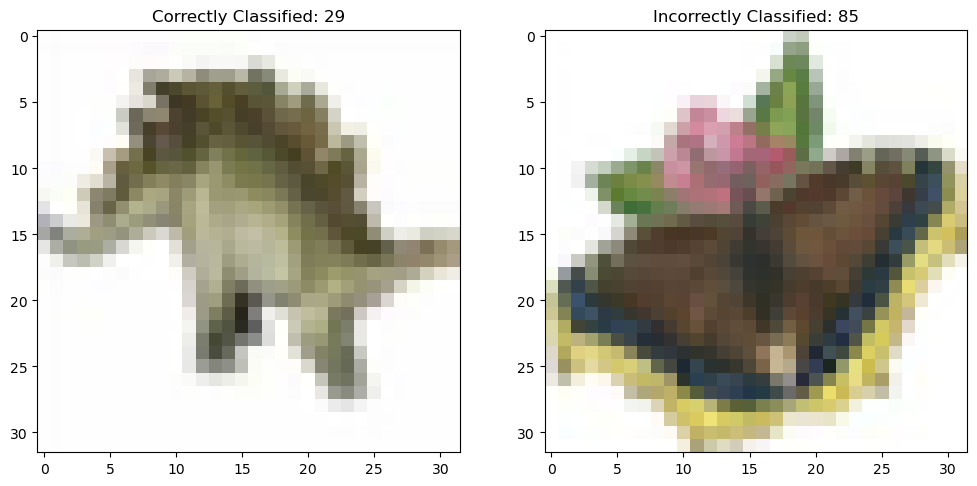

In [84]:

import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_test_classes = y_test.argmax(axis=-1)  # Convert one-hot to class labels

# Select an image that the model classified correctly
correct_index = np.where(y_pred_classes == y_test_classes)[0]
incorrect_index = np.where(y_pred_classes != y_test_classes)[0]

# Randomly pick one correctly classified and one incorrectly classified image
correct_image = np.random.choice(correct_index)
incorrect_image = np.random.choice(incorrect_index)

# Plot images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x_test[correct_image])
plt.title(f'Correctly Classified: {y_pred_classes[correct_image]}')
print("Correctly Classified Image")
print(y_pred[correct_image])

plt.subplot(1, 2, 2)
plt.imshow(x_test[incorrect_image])
plt.title(f'Incorrectly Classified: {y_pred_classes[incorrect_image]}')
print("\nIncorrectly Classified Image:")
print(y_pred[incorrect_image])

plt.show()




## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.

    I will use Data Augmentation given that it adds some randomness to the training data set which will help with overfitting 

- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [85]:
# Your code here

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

#Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

#Fitting to training data
datagen.fit(x_train)

#Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])


Epoch 1/50
1250/1250 [==============================] - 103s 82ms/step - loss: 3.0427 - accuracy: 0.2559 - val_loss: 2.6885 - val_accuracy: 0.3320
Epoch 2/50
1250/1250 [==============================] - 105s 84ms/step - loss: 2.9970 - accuracy: 0.2622 - val_loss: 2.6713 - val_accuracy: 0.3363
Epoch 3/50
1250/1250 [==============================] - 107s 85ms/step - loss: 2.9577 - accuracy: 0.2684 - val_loss: 2.6234 - val_accuracy: 0.3413
Epoch 4/50
1250/1250 [==============================] - 107s 85ms/step - loss: 2.9213 - accuracy: 0.2768 - val_loss: 2.6225 - val_accuracy: 0.3479
Epoch 5/50
1250/1250 [==============================] - 107s 86ms/step - loss: 2.8955 - accuracy: 0.2810 - val_loss: 2.5538 - val_accuracy: 0.3603
Epoch 6/50
1250/1250 [==============================] - 108s 86ms/step - loss: 2.8706 - accuracy: 0.2874 - val_loss: 2.5542 - val_accuracy: 0.3603
Epoch 7/50
1250/1250 [==============================] - 108s 87ms/step - loss: 2.8485 - accuracy: 0.2895 - val_loss: 2

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

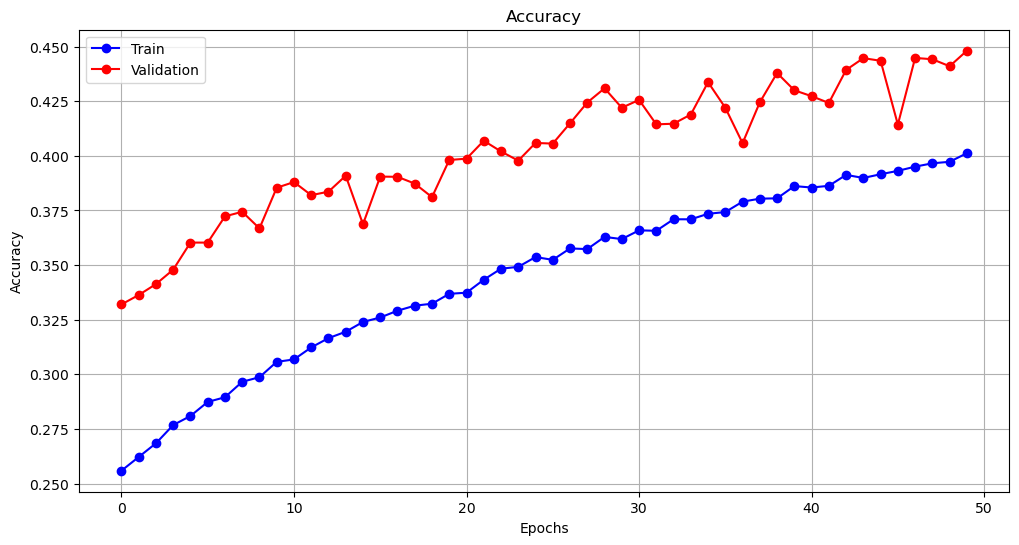

In [86]:
# Your code here

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], 'bo-', label='Train')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

313/313 [==============================] - 7s 21ms/step
Correctly Classified Image
[9.2914300e-03 6.7683210e-04 1.6360898e-02 2.6765310e-03 2.5210204e-03
 4.2194095e-03 5.5664685e-03 2.8364495e-03 3.9937667e-04 2.9772944e-03
 9.7084818e-03 7.8023309e-03 7.9188793e-04 1.2175678e-03 2.7742121e-02
 2.9421379e-03 9.3115335e-03 1.8282588e-04 3.7244104e-03 1.6498705e-03
 1.8739590e-04 3.4126436e-04 4.7560506e-02 2.7248227e-05 2.6761915e-03
 2.1122301e-03 2.4790781e-02 1.2906423e-03 8.2259334e-04 9.1828202e-04
 7.6025841e-05 1.1715472e-04 3.0532579e-03 4.5886173e-04 1.9092537e-03
 3.5559908e-02 6.2167649e-03 7.0918677e-03 1.5957723e-03 9.4775390e-03
 6.7449696e-03 3.0707014e-03 1.4602114e-03 6.8895598e-03 6.4106570e-03
 1.1232094e-02 4.2638397e-03 9.8109187e-05 1.1114705e-03 8.9059831e-06
 1.6759258e-02 7.0734233e-02 1.4477691e-05 2.4294581e-03 1.8709511e-02
 2.0900113e-03 2.6080927e-05 1.0948730e-02 1.0189078e-03 1.2847979e-04
 6.0324946e-06 5.2884065e-02 2.5441281e-02 3.0328014e-03 4.139184

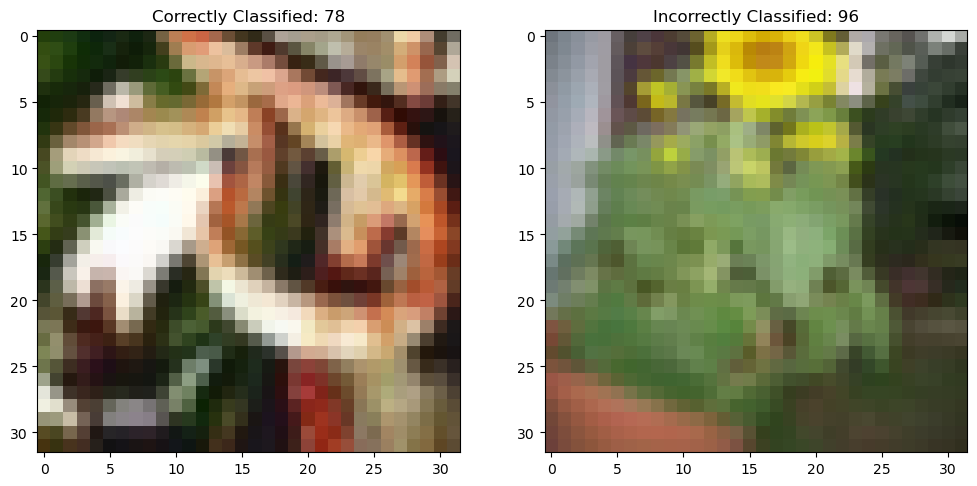

In [87]:
# Get model predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class labels
y_test_classes = y_test.argmax(axis=-1)  # Convert one-hot to class labels

# Select an image that the model classified correctly
correct_index = np.where(y_pred_classes == y_test_classes)[0]
incorrect_index = np.where(y_pred_classes != y_test_classes)[0]

# Randomly pick one correctly classified and one incorrectly classified image
correct_image = np.random.choice(correct_index)
incorrect_image = np.random.choice(incorrect_index)

# Plot images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x_test[correct_image])
plt.title(f'Correctly Classified: {y_pred_classes[correct_image]}')
print("Correctly Classified Image")
print(y_pred[correct_image])

plt.subplot(1, 2, 2)
plt.imshow(x_test[incorrect_image])
plt.title(f'Incorrectly Classified: {y_pred_classes[incorrect_image]}')
print("\nIncorrectly Classified Image:")
print(y_pred[incorrect_image])

plt.show()

In [88]:
y_pred = model.predict(x_test) 
y_pred_classes = y_pred.argmax(axis=-1)  

#  one-hot  
y_test_classes = y_test.argmax(axis=-1)  

# Compute F1-Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1-Score: {f1:.4f}')

313/313 [==============================] - 6s 20ms/step
F1-Score: 0.4333


### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
    Yes, from 0.3250 to 0.4012 on the trainin set and from 0.3469 to 0.4481 on the validation set

- Why do you think this is?

    To the implementation of the Data Augmentation given that it slightly and randomly transforms some of the images it adds a slighlty more random training set to learn from, which in turn helps the model
    to adapt the validation data.

- Do you think there is room for further improvement? Why or why not?

    yes, since bot curves seems like they haven't reached their plateau yet.

- What other techniques might you try in the future?

    Learning rate schedulers to dinamically change the learning rate, and I wouldn't do any changes to prevent overfitting like more dropouts since it seems like the .

- Your answer should be no more than 200 words.

# Your answer here

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.